In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from numba import njit, jit, prange
sns.set_style("whitegrid")

The reaction goes as,

$$ a \,\mathbf{r} + b\, \mathbf{s} \rightleftharpoons b\, \mathbf{c} $$

where $\alpha = \frac{a}{b} = 1.5$ in the paper

# Initialisation

In [2]:
a = 3
b = 2
alpha = a/b

S = 100

r_init = S*1 #int(S*0.35)
s_init = S*1 #int(S*0.5)
c_init = S*0 #int(S*0.5)

In [3]:
#fit_parameters = np.load(r'C:\Users\Rohit Vasav\Downloads\params_f_range.npz')
#k_off, k_u, k_b, j_off, J_on_hat, g_off = fit_parameters['params'][0,0]

## Parameters obtained from experimental data
k_off, k_u, k_b, j_off, J_on_hat, g_off = [3.9018766517549692, 1.9799379861044861, 6.615504603306438, 
                                           3.481669158554892, 3.016688368288114, 5.910017828840013]

G_on = J_on_hat/(1+j_off/g_off)
J_on = J_on_hat - G_on

K_on = k_off/(1+(k_b/k_u)*J_on_hat/(j_off+g_off)) - G_on + g_off*J_on_hat/(j_off+g_off)

## Theoretical steady state values
r_star = J_on_hat / (j_off + g_off)
s_star = (K_on + G_on -g_off*r_star) / k_off
c_star = k_b/k_u * r_star * s_star

## Scaling the parameters with S
J_on *= S
G_on *= S
k_b /= S
K_on *= S

r_star *= S
s_star *= S
c_star *= S

In [4]:
num_trials = 2000
end_time = 150*S

# Gillespie Simulations

In [5]:
@njit(parallel=True)
def stochastic_process(r_init, s_init, c_init, num_trials, end_time):
    
    r = np.zeros((num_trials,end_time),dtype=np.int32)
    s = np.zeros((num_trials,end_time),dtype=np.int32)
    c = np.zeros((num_trials,end_time),dtype=np.int32)

    time_arr = np.zeros((num_trials,end_time),dtype=np.float64)

    r[:,0] = r_init
    s[:,0] = s_init
    c[:,0] = c_init

    for trial in prange(num_trials):

        for t in prange(1,end_time):

            rates = np.array([J_on, G_on, k_u*c[trial,t-1]/b, g_off*r[trial,t-1], j_off*r[trial,t-1], 
                         k_b*r[trial,t-1]*s[trial,t-1]/b, K_on, k_off*s[trial,t-1]],dtype=np.float64)

            if r[trial,t-1] < a or s[trial,t-1] < b:
                rates[5] *= 0
                if s[trial,t-1] == 0:
                    rates[3] *= 0

            if c[trial,t-1] < b:
                rates[2] *= 0

            K = np.sum(rates)

            time_arr[trial,t] = time_arr[trial,t-1] + np.random.exponential(1/K)

            rates /= K
            cum_rates = np.cumsum(rates)

            dr = np.array([1,1,a,-1,-1,-a,0,0],dtype=np.int8)
            ds = np.array([0,1,b,-1,0,-b,1,-1],dtype=np.int8)
            dc = np.array([0,0,-b,0,0,b,0,0],dtype=np.int8)

            u = np.random.uniform(0,1)
            ind = np.searchsorted(cum_rates,u)

            r[trial,t] = r[trial,t-1] + dr[ind]
            s[trial,t] = s[trial,t-1] + ds[ind]
            c[trial,t] = c[trial,t-1] + dc[ind]

            if r[trial,t] < 0 or s[trial,t] < 0 or c[trial,t] < 0:
                print(trial,t)
                
    return r,s,c,time_arr

In [6]:
r,s,c,time_arr = stochastic_process(r_init, s_init, c_init, num_trials, end_time)

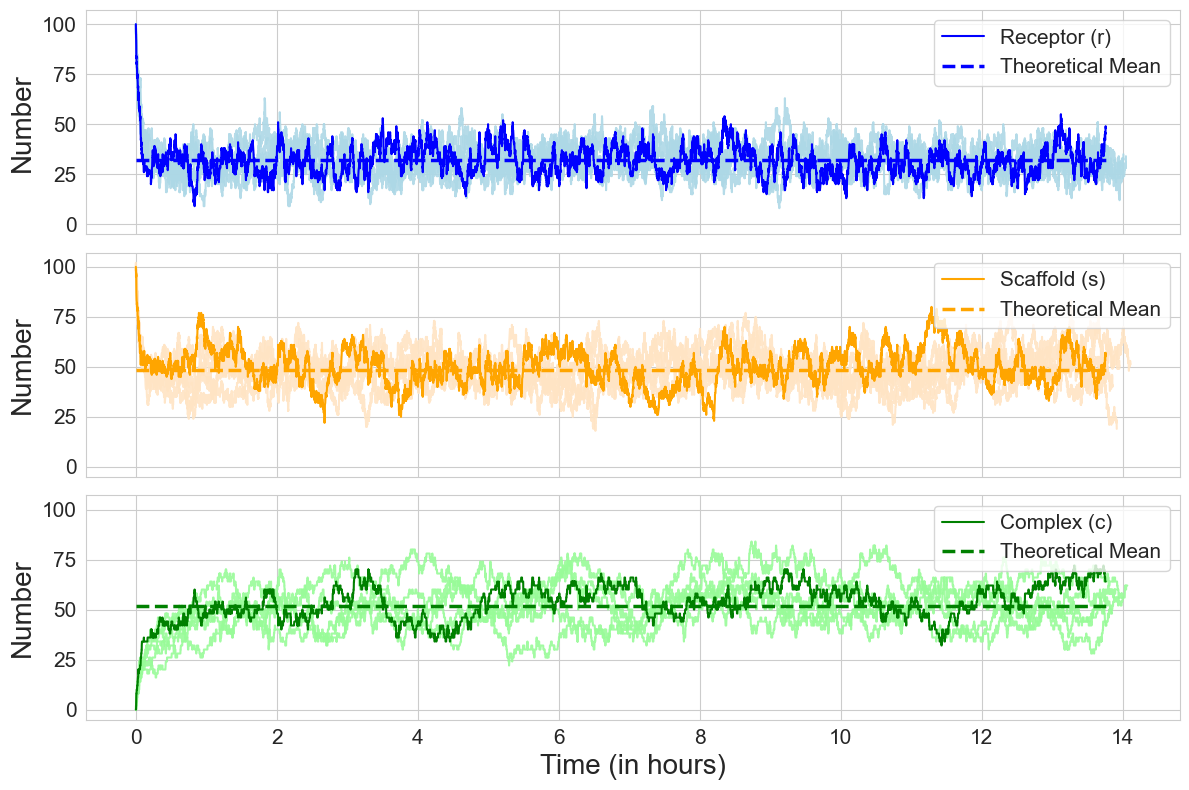

In [7]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

for i in np.random.randint(1,num_trials,5):
    axs[0].plot(time_arr[i,:],r[i,:],color='lightblue',alpha=0.9)
axs[0].plot(time_arr[0,:],r[0,:],color='blue',label = "Receptor (r)")
axs[0].hlines(r_star,xmin=0,xmax=max(time_arr[0,:]),color='blue',ls='--',lw=2.5,label="Theoretical Mean")
axs[0].set_ylabel("Number", fontsize = 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].legend(fontsize=15, loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[1].plot(time_arr[i,:],s[i,:],color='bisque',alpha=0.9)
axs[1].plot(time_arr[0,:],s[0,:],color='orange',label="Scaffold (s)")
axs[1].hlines(s_star,xmin=0,xmax=max(time_arr[0,:]),color='orange',ls='--',lw=2.5,label="Theoretical Mean")
axs[1].set_ylabel("Number", fontsize = 20)
axs[1].tick_params(axis='both', labelsize=15)
axs[1].legend(fontsize=15, loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[2].plot(time_arr[i,:],c[i,:],color='palegreen',alpha=0.9)
axs[2].plot(time_arr[0,:],c[0,:],color='green',label="Complex (c)")
axs[2].hlines(c_star,xmin=0,xmax=max(time_arr[0,:]),color='green',ls='--',lw=2.5,label="Theoretical Mean")
axs[2].set_ylabel("Number", fontsize = 20)
axs[2].set_xlabel("Time (in hours)", fontsize = 20)
axs[2].tick_params(axis='both', labelsize=15)
axs[2].legend(fontsize=15, loc='upper right')

#fig.suptitle('Some random trajectories')
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Some_random_trajectories.png",dpi=150)
plt.show()

# Binning and Average Trajectories

In [8]:
@njit(parallel=True)
def binning_process(unif_time_arr,time_arr,num_trials,bin_num):
    
    mod_r = np.zeros((num_trials,bin_num),dtype=np.int32)
    mod_s = np.zeros((num_trials,bin_num),dtype=np.int32)
    mod_c = np.zeros((num_trials,bin_num),dtype=np.int32)

    mod_r[:,0] = r[:,0]
    mod_s[:,0] = s[:,0]
    mod_c[:,0] = c[:,0]
    
    for trial in prange(num_trials):
    
        idx = np.searchsorted(time_arr[trial,:],unif_time_arr,side='right')

        for i in prange(1,bin_num):

            mod_r[trial,i] = r[trial,idx[i]-1]
            mod_s[trial,i] = s[trial,idx[i]-1]
            mod_c[trial,i] = c[trial,idx[i]-1]
            
    return mod_r, mod_s, mod_c

In [9]:
bin_size = 1/60 * 1/60  ## 1 second
unif_time_arr = np.arange(0,np.min(time_arr[:,-1])+bin_size,bin_size)
bin_num = len(unif_time_arr)

mod_r, mod_s, mod_c = binning_process(unif_time_arr,time_arr,num_trials,bin_num)
        
mean_r = np.mean(mod_r,axis=0)
mean_s = np.mean(mod_s,axis=0)
mean_c = np.mean(mod_c,axis=0)

std_r = np.std(mod_r,axis=0)
std_s = np.std(mod_s,axis=0)
std_c = np.std(mod_c,axis=0)

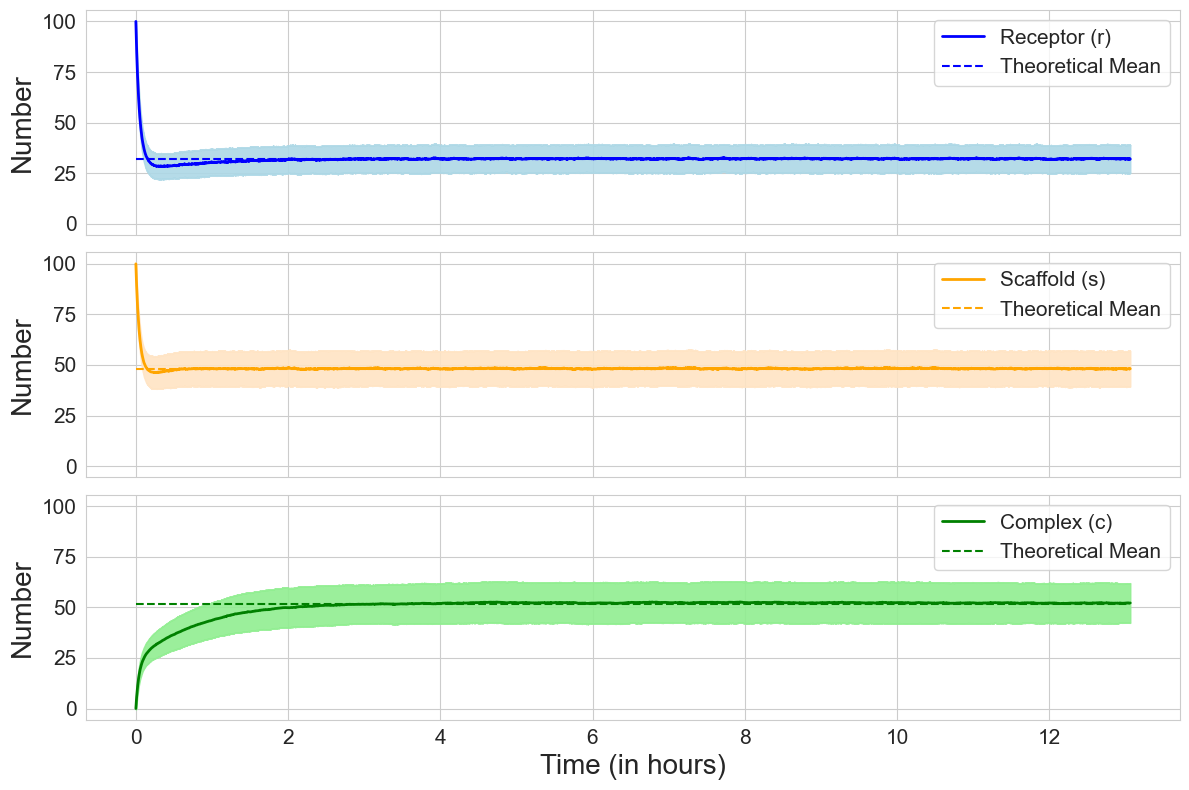

In [10]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

axs[0].fill_between(unif_time_arr, mean_r-std_r, mean_r+std_r, color='lightblue',alpha=0.9)
axs[0].plot(unif_time_arr,mean_r,color='blue',lw=2, label = "Receptor (r)")
axs[0].hlines(r_star,xmin=0,xmax=max(unif_time_arr),color='blue',ls='--',lw=1.5,label="Theoretical Mean")
axs[0].set_ylabel("Number", fontsize = 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].legend(fontsize=15, loc='upper right')

axs[1].fill_between(unif_time_arr, mean_s-std_s, mean_s+std_s, color='bisque',alpha=0.9)
axs[1].plot(unif_time_arr,mean_s,color='orange',lw=2, label="Scaffold (s)")
axs[1].hlines(s_star,xmin=0,xmax=max(unif_time_arr),color='orange',ls='--',lw=1.5,label="Theoretical Mean")
axs[1].set_ylabel("Number", fontsize = 20)
axs[1].tick_params(axis='both', labelsize=15)
axs[1].legend(fontsize=15, loc='upper right')

axs[2].fill_between(unif_time_arr, mean_c-std_c, mean_c+std_c, color='lightgreen',alpha=0.9)
axs[2].plot(unif_time_arr,mean_c,color='green',lw=2, label="Complex (c)")
axs[2].hlines(c_star,xmin=0,xmax=max(unif_time_arr),color='green',ls='--',lw=1.5,label="Theoretical Mean")
axs[2].set_ylabel("Number", fontsize = 20)
axs[2].set_xlabel("Time (in hours)", fontsize = 20)
axs[2].tick_params(axis='both', labelsize=15)
axs[2].legend(fontsize=15, loc='upper right')

#fig.suptitle('Ensemble average trajectories')
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Ensemble_average_trajectories.png",dpi=150)
plt.show()

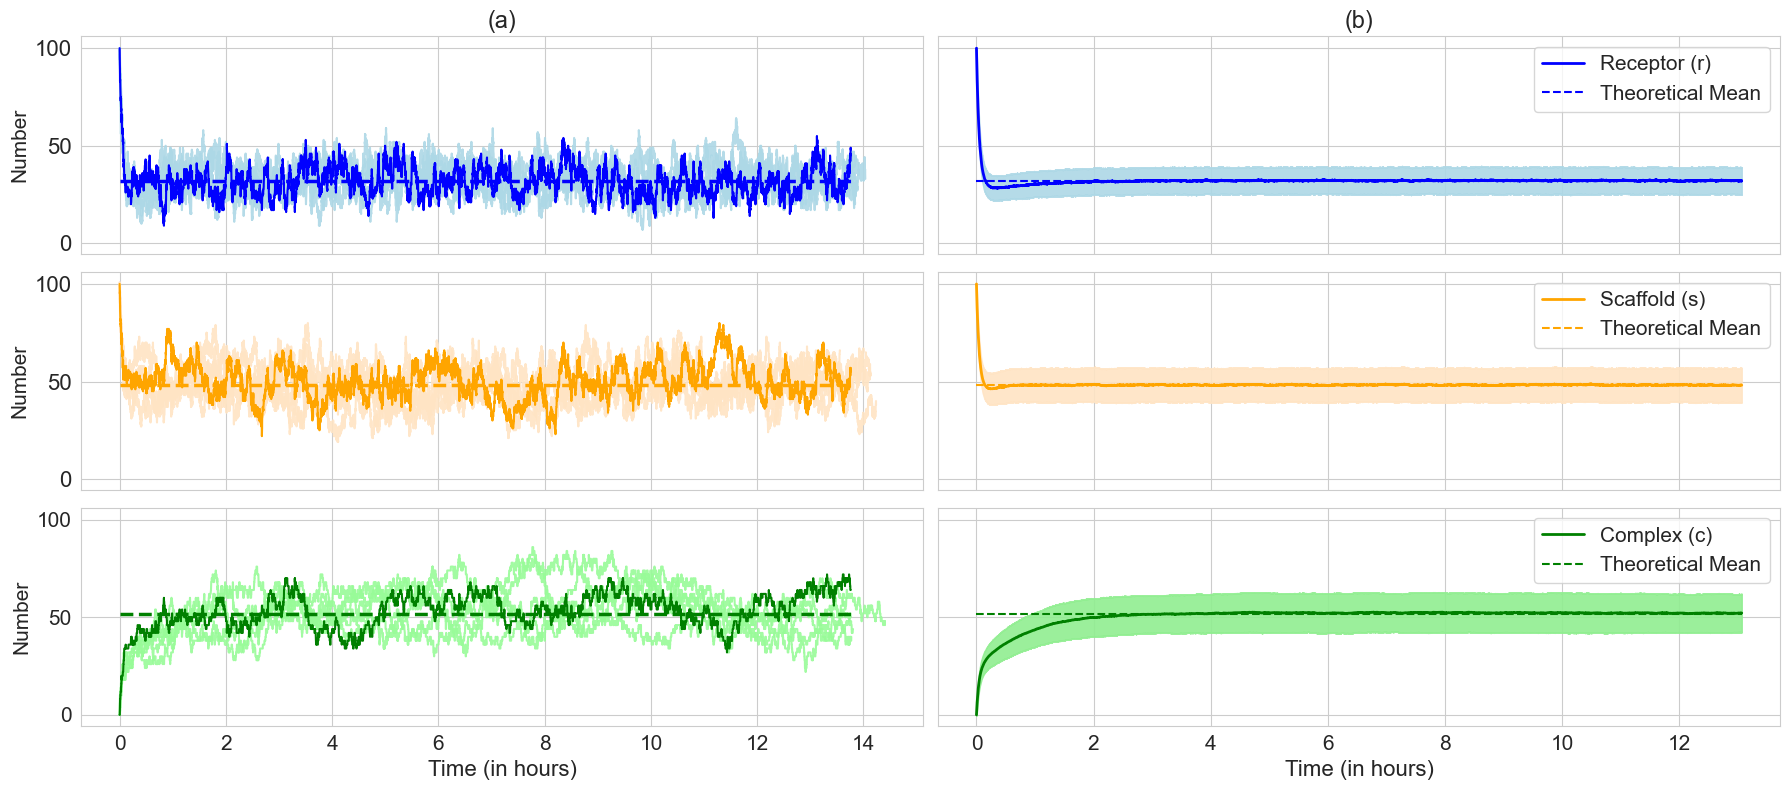

In [11]:
fig, axs = plt.subplots(3,2, figsize=(18,8), sharex='col', sharey=True)



for i in np.random.randint(1,num_trials,5):
    axs[0,0].plot(time_arr[i,:],r[i,:],color='lightblue',alpha=0.9)
axs[0,0].plot(time_arr[0,:],r[0,:],color='blue',label = "Receptor (r)")
axs[0,0].hlines(r_star,xmin=0,xmax=max(time_arr[0,:]),color='blue',ls='--',lw=2.5,label="Theoretical Mean")
axs[0,0].set_ylabel("Number", fontsize = 15)
axs[0,0].tick_params(axis='both', labelsize=16)
axs[0,0].set_title('(a)',fontsize=17)
#axs[0,0].legend(fontsize=15, loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[1,0].plot(time_arr[i,:],s[i,:],color='bisque',alpha=0.9)
axs[1,0].plot(time_arr[0,:],s[0,:],color='orange',label="Scaffold (s)")
axs[1,0].hlines(s_star,xmin=0,xmax=max(time_arr[0,:]),color='orange',ls='--',lw=2.5,label="Theoretical Mean")
axs[1,0].set_ylabel("Number", fontsize = 15)
axs[1,0].tick_params(axis='both', labelsize=16)
#axs[1,0].legend(fontsize=15, loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[2,0].plot(time_arr[i,:],c[i,:],color='palegreen',alpha=0.9)
axs[2,0].plot(time_arr[0,:],c[0,:],color='green',label="Complex (c)")
axs[2,0].hlines(c_star,xmin=0,xmax=max(time_arr[0,:]),color='green',ls='--',lw=2.5,label="Theoretical Mean")
axs[2,0].set_ylabel("Number", fontsize = 15)
axs[2,0].set_xlabel("Time (in hours)", fontsize = 16)
axs[2,0].tick_params(axis='both', labelsize=15)
#axs[2,0].legend(fontsize=15, loc='upper right')




axs[0,1].fill_between(unif_time_arr, mean_r-std_r, mean_r+std_r, color='lightblue',alpha=0.9)
axs[0,1].plot(unif_time_arr,mean_r,color='blue',lw=2, label = "Receptor (r)")
axs[0,1].hlines(r_star,xmin=0,xmax=max(unif_time_arr),color='blue',ls='--',lw=1.5,label="Theoretical Mean")
axs[0,1].tick_params(axis='both', labelsize=15)
axs[0,1].legend(fontsize=15, loc='upper right')
axs[0,1].set_title('(b)',fontsize=17)

axs[1,1].fill_between(unif_time_arr, mean_s-std_s, mean_s+std_s, color='bisque',alpha=0.9)
axs[1,1].plot(unif_time_arr,mean_s,color='orange',lw=2, label="Scaffold (s)")
axs[1,1].hlines(s_star,xmin=0,xmax=max(unif_time_arr),color='orange',ls='--',lw=1.5,label="Theoretical Mean")
axs[1,1].tick_params(axis='both', labelsize=15)
axs[1,1].legend(fontsize=15, loc='upper right')

axs[2,1].fill_between(unif_time_arr, mean_c-std_c, mean_c+std_c, color='lightgreen',alpha=0.9)
axs[2,1].plot(unif_time_arr,mean_c,color='green',lw=2, label="Complex (c)")
axs[2,1].hlines(c_star,xmin=0,xmax=max(unif_time_arr),color='green',ls='--',lw=1.5,label="Theoretical Mean")
axs[2,1].set_xlabel("Time (in hours)", fontsize = 16)
axs[2,1].tick_params(axis='both', labelsize=15)
axs[2,1].legend(fontsize=15, loc='upper right')

#fig.suptitle('Ensemble average trajectories')
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Alltrajectories.png",dpi=200)
plt.show()

# Equilibrium Statistics and Distributions

In [12]:
r_stat = mod_r[:,bin_num//2:].flatten()
s_stat = mod_s[:,bin_num//2:].flatten()
c_stat = mod_c[:,bin_num//2:].flatten()

num_stat = r_stat.shape[0]

mu_r, sigma_r = np.mean(r_stat), np.std(r_stat)
mu_s, sigma_s = np.mean(s_stat), np.std(s_stat)
mu_c, sigma_c = np.mean(c_stat), np.std(c_stat)

print(num_stat)
print(mu_r, r_star, abs(mu_r-r_star)/r_star * 100,"% error")
print(mu_s, s_star, abs(mu_s-s_star)/s_star * 100,"% error")
print(mu_c, c_star, abs(mu_c-c_star)/c_star * 100,"% error")
print((mu_s + mu_c)/S, abs((mu_s + mu_c)/S - 1)*100,"% error")

print(sigma_r,sigma_s,sigma_c)

np.save('/users/nsr/rvasav/Internship/Data/r_stat.npy', r_stat)
np.save('/users/nsr/rvasav/Internship/Data/s_stat.npy', s_stat)
np.save('/users/nsr/rvasav/Internship/Data/c_stat.npy', c_stat)

47036000
32.12402023981631 32.120835930083445 0.009913533196325583 % error
48.25093354026703 48.23360340267108 0.035929593423220274 % error
52.28494816736117 51.766396597328914 1.0017146336567977 % error
1.005358817076282 0.5358817076281941 % error
6.9314301650969075 8.723845968211876 10.056761652607618


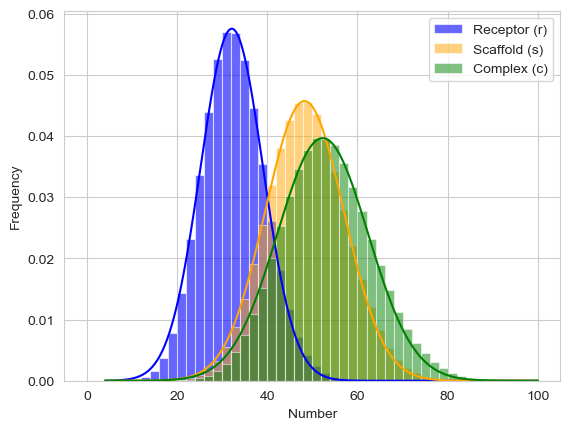

In [13]:
x = np.arange(min([np.min(r_stat),np.min(s_stat),np.min(c_stat)]),
              max([np.max(r_stat),np.max(s_stat),np.max(c_stat)]), 0.01)

y_r = stats.norm.pdf(x, mu_r, sigma_r)
y_s = stats.norm.pdf(x, mu_s, sigma_s)
y_c = stats.norm.pdf(x, mu_c, sigma_c)

plt.hist(r_stat,bins=range(0,S+1,b),density=True,label='Receptor (r)',facecolor = 'blue',edgecolor = 'white',linewidth=0.8,alpha=0.6)
plt.hist(s_stat,bins=range(0,S+1,b),density=True,label='Scaffold (s)',facecolor = 'orange',edgecolor = 'white',linewidth=0.8,alpha=0.5)
plt.hist(c_stat,bins=range(0,S+1,b),density=True,label='Complex (c)',facecolor = 'green',edgecolor = 'white',linewidth=0.8,alpha=0.5)

plt.plot(x,y_r,color='blue')
plt.plot(x,y_s,color='orange')
plt.plot(x,y_c,color='green')

plt.ylabel('Frequency')
plt.xlabel("Number")

plt.legend()

#plt.title('Equilibrium Probablity Distributions')
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Equilibrium_Probablity_Distributions(same_fig).png",dpi=150)
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

datasets = [(r_stat, 'Receptor (r)'), (s_stat, 'Scaffold (s)'), (c_stat, 'Complex (c)')]

for i, (data, title) in enumerate(datasets):
    ax = axs[i]
    stats.probplot(data, plot=ax)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel('Theoretical quantiles',fontsize=15)
    ax.set_ylabel('Ordered values',fontsize=15)
    ax.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/QQPlots.png",dpi=150)
plt.show()

# Correlation Functions

In [14]:
@njit(parallel=True)
def correlation_function(data_a, data_b, num_trials, N_tau):
    
    cf_arr = np.zeros((num_trials,N_tau),dtype=np.float64)
    cf_arr[:,0] = np.sum(data_a*data_b,axis=1)/N_tau
    
    for trial in prange(num_trials):
        for l in prange(1,N_tau):
            tmp = np.sum(data_a[trial,l:][:N_tau-l]*data_b[trial,:-l][:N_tau-l])
            cf_arr[trial,l] = tmp / (N_tau-l)

    cf = np.sum(cf_arr, axis=0)/num_trials
    return cf

In [15]:
def pair_correlation_function(data_a, data_b, num_trials, N_tau):
    return np.concatenate( ( np.flip(correlation_function(data_b,data_a,num_trials,N_tau)[1:]),
                     correlation_function(data_a,data_b,num_trials,N_tau) ) )

## Autocorrelation Function

$$C_{xx}(\tau) = \langle\, \tilde{x}(t+\tau)\;\tilde{x}(t)\,\rangle \sim e^{-\tau/\tau_c}$$

where $\tilde{x} = \frac{x-\mu_x}{\sigma_x}$

In [16]:
r_norm = (mod_r[:,bin_num//2:]-r_star)/sigma_r
s_norm = (mod_s[:,bin_num//2:]-s_star)/sigma_s
c_norm = (mod_c[:,bin_num//2:]-c_star)/sigma_c

N_tau = r_norm.shape[1]
acf_tau_arr = unif_time_arr[:N_tau]
    
acf_r = correlation_function(r_norm, r_norm, num_trials, N_tau)
acf_s = correlation_function(s_norm, s_norm, num_trials, N_tau)
acf_c = correlation_function(c_norm, c_norm, num_trials, N_tau)

np.save('/users/nsr/rvasav/Internship/Data/acf_r.npy', acf_r)
np.save('/users/nsr/rvasav/Internship/Data/acf_s.npy', acf_s)
np.save('/users/nsr/rvasav/Internship/Data/acf_c.npy', acf_c)
np.save('/users/nsr/rvasav/Internship/Data/acf_tau_arr.npy', acf_tau_arr)

In [17]:
mod_acf_r = acf_r[acf_r>=0.07]
mod_unif_time_arr_r = unif_time_arr[:len(mod_acf_r),np.newaxis]

a_r, res_r,_,_ = np.linalg.lstsq(mod_unif_time_arr_r,np.log(mod_acf_r),rcond=None)
tau_c_r = -1/a_r

mod_acf_s = acf_s[acf_s>=0.05]
mod_unif_time_arr_s = unif_time_arr[:len(mod_acf_s),np.newaxis]

a_s, res_s,_,_ = np.linalg.lstsq(mod_unif_time_arr_s,np.log(mod_acf_s),rcond=None)
tau_c_s = -1/a_s

mod_acf_c = acf_c[acf_c>=0.03]
mod_unif_time_arr_c = unif_time_arr[:len(mod_acf_c),np.newaxis]

a_c, res_c,_,_ = np.linalg.lstsq(mod_unif_time_arr_c,np.log(mod_acf_c),rcond=None)
tau_c_c = -1/a_c

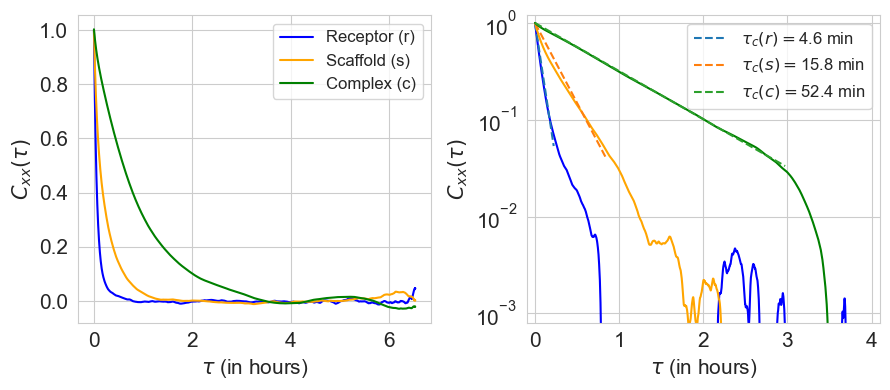

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].plot(acf_tau_arr, acf_r,color='blue', label='Receptor (r)')
axs[0].plot(acf_tau_arr, acf_s,color='orange', label='Scaffold (s)')
axs[0].plot(acf_tau_arr, acf_c,color='green', label='Complex (c)')
axs[0].set_xlabel(r"$\tau$ (in hours)", fontsize = 15)
axs[0].set_ylabel(r"$C_{xx}(\tau)$",fontsize=15)
axs[0].legend(fontsize=12, loc='upper right')
axs[0].tick_params(axis='both', labelsize=15)

axs[1].plot(acf_tau_arr,acf_r,color='blue')
axs[1].plot(mod_unif_time_arr_r,np.exp(-mod_unif_time_arr_r/tau_c_r),'--',label=r'$\tau_c(r)=$'+str((tau_c_r[0]*60).round(1))+" min")

axs[1].plot(acf_tau_arr,acf_s,color='orange')
axs[1].plot(mod_unif_time_arr_s,np.exp(-mod_unif_time_arr_s/tau_c_s),'--',label=r'$\tau_c(s)=$'+str((tau_c_s[0]*60).round(1))+" min")

axs[1].plot(acf_tau_arr,acf_c,color='green')
axs[1].plot(mod_unif_time_arr_c,np.exp(-mod_unif_time_arr_c/tau_c_c),'--',label=r'$\tau_c(c)=$'+str((tau_c_c[0]*60).round(1))+" min")

axs[1].set_yscale('log',base=10)
axs[1].set_xlabel(r"$\tau$ (in hours)",fontsize=15)
axs[1].set_ylabel(r"$C_{xx}(\tau)$",fontsize=15)
axs[1].legend(fontsize=12, loc='upper right')
axs[1].set_ylim(0.0008,1.2)
axs[1].set_xlim(-0.1,4.1)
axs[1].tick_params(axis='both', labelsize=15)

#fig.suptitle("Auto-Correlation Functions \n S = "+str(S))
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Auto_Correlation_Functions(S="+str(S)+").png",dpi=150)
plt.show()

In [19]:
tau_c_r*60, tau_c_s*60, tau_c_c*60

(array([4.5501585]), array([15.76557695]), array([52.4047405]))

In [20]:
tau_c_r_arr = np.array([4.67366668, 4.50931207, 4.63041633, 4.59226946, 4.55887045, 4.45620134, 4.60722484, 4.5642365])
tau_c_s_arr = np.array([14.34766992, 14.55228541, 14.76027507, 14.72844604, 14.606883, 14.71131894, 14.96456016, 14.71800231])
tau_c_c_arr = np.array([47.65978391, 46.06650598, 52.23338883, 45.93284642, 50.51079346, 49.2306622, 46.73976391, 50.18304125])

In [21]:
print(np.mean(tau_c_r_arr).round(2), np.std(tau_c_r_arr).round(2))
print(np.mean(tau_c_s_arr).round(2), np.std(tau_c_s_arr).round(2))
print(np.mean(tau_c_c_arr).round(2), np.std(tau_c_c_arr).round(2))

4.57 0.06
14.67 0.17
48.57 2.17


## Pair Correlation Functions

$$C_{xy}(\tau) = \langle \,\tilde{x}(t+\tau)\;\tilde{y}(t)\, \rangle$$

where $\tilde{x} = \frac{x-\mu_x}{\sigma_x}$ and $\tilde{y} = \frac{y-\mu_y}{\sigma_y}$

In [22]:
cf_rs = pair_correlation_function(r_norm, s_norm, num_trials, N_tau)
cf_sc = pair_correlation_function(s_norm, c_norm, num_trials, N_tau)
cf_rc = pair_correlation_function(r_norm, c_norm, num_trials, N_tau)

cf_rs = np.flip(cf_rs)  ## flipping to make <r(t+dt)s(t)> --> <r(t)s(t+dt)> to match the Langevin theory
cf_sc = np.flip(cf_sc)
cf_rc = np.flip(cf_rc)

#cf_rs = pair_correlation_function(mod_r[:,bin_num//2:], mod_s[:,bin_num//2:], num_trials, N_tau)
#cf_sc = pair_correlation_function(mod_s[:,bin_num//2:], mod_c[:,bin_num//2:], num_trials, N_tau)
#cf_rc = pair_correlation_function(mod_r[:,bin_num//2:], mod_c[:,bin_num//2:], num_trials, N_tau)

cf_tau_arr = np.concatenate((-np.flip(unif_time_arr[1:N_tau]),unif_time_arr[:N_tau]))

np.save('/users/nsr/rvasav/Internship/Data/cf_rs.npy', cf_rs)
np.save('/users/nsr/rvasav/Internship/Data/cf_sc.npy', cf_sc)
np.save('/users/nsr/rvasav/Internship/Data/cf_rc.npy', cf_rc)
np.save('/users/nsr/rvasav/Internship/Data/cf_tau_arr.npy', cf_tau_arr)

In [23]:
cov = [0.2692743994739339, 0.13784955439946364, -0.14434826976381504]

In [24]:
cf_rs[N_tau-1], cf_sc[N_tau-1], cf_rc[N_tau-1]

(0.2750565197577409, 0.1397079416894661, -0.14923119099974108)

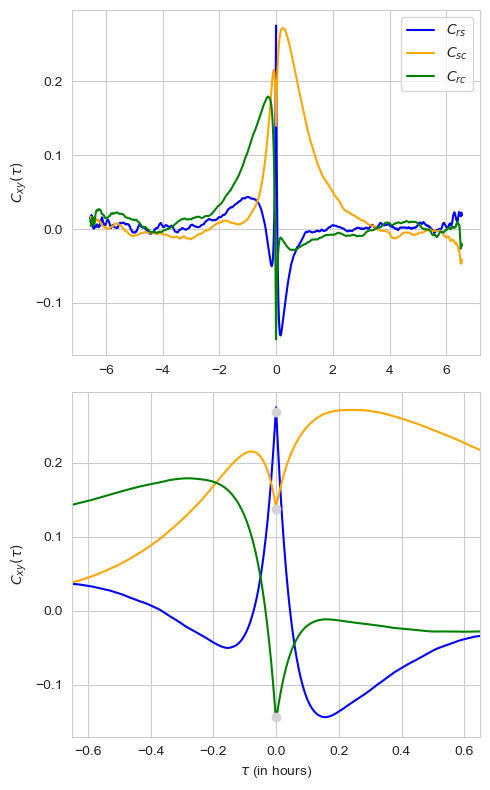

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(5,8))

axs[0].plot(cf_tau_arr, cf_rs, label="$C_{rs}$", color='blue')
axs[0].plot(cf_tau_arr, cf_sc, label='$C_{sc}$', color='orange')
axs[0].plot(cf_tau_arr, cf_rc, label='$C_{rc}$', color='green')
#axs[0].set_xlabel(r"$\tau$ (in hours)")
axs[0].set_ylabel(r"$C_{xy}(\tau)$")
#axs[0].set_ylim(-0.17,0.3)
#axs[0].set_xlim(-0.3,0.3)
axs[0].legend(fontsize=10)

axs[1].plot(cf_tau_arr, cf_rs, color='blue')
axs[1].plot(cf_tau_arr, cf_sc, color='orange')
axs[1].plot(cf_tau_arr, cf_rc, color='green')
axs[1].plot([0,0,0],cov,'.',markersize=12, color='lightgrey')
axs[1].set_xlabel(r"$\tau$ (in hours)")
axs[1].set_ylabel(r"$C_{xy}(\tau)$")
#axs[1].set_yscale('log',base=10)
#axs[1].set_ylim(0.01,0.4)
axs[1].set_xlim(-0.65,0.65)
#fig.suptitle("Correlation Functions \n S = "+str(S))
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Correlation_Functions(S="+str(S)+").png",dpi=150)
plt.show()

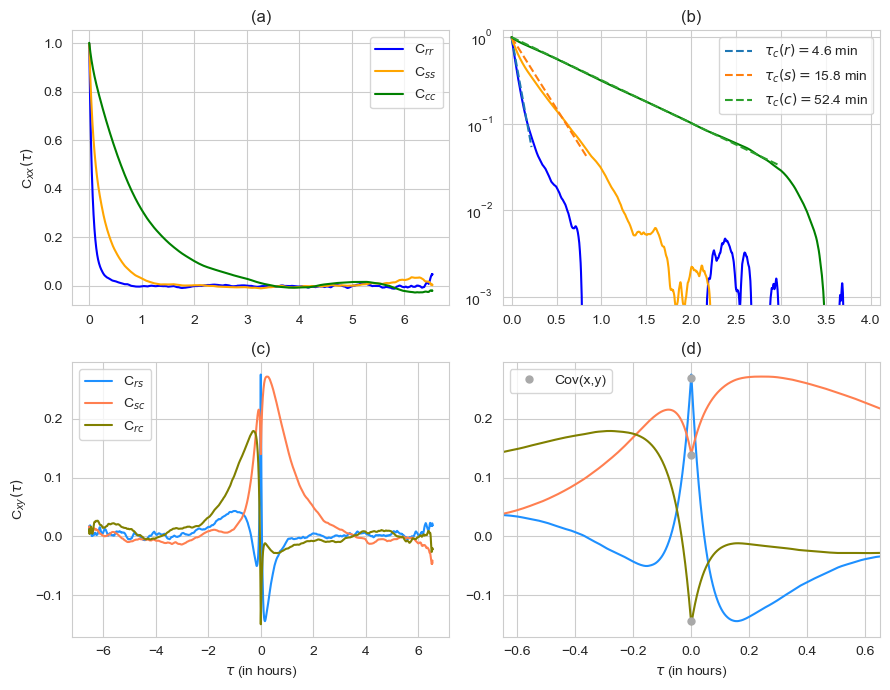

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(9,7))

axs[0,0].plot(acf_tau_arr, acf_r,color='blue', label='C$_{rr}$')
axs[0,0].plot(acf_tau_arr, acf_s,color='orange', label='C$_{ss}$')
axs[0,0].plot(acf_tau_arr, acf_c,color='green', label='C$_{cc}$')
#axs[0,0].set_xlabel(r"$\tau$ (in hours)")
axs[0,0].set_ylabel(r"C$_{xx}(\tau)$")
axs[0,0].legend(fontsize=10, loc='upper right')
axs[0,0].set_title('(a)')

axs[0,1].plot(acf_tau_arr,acf_r,color='blue')
axs[0,1].plot(mod_unif_time_arr_r,np.exp(-mod_unif_time_arr_r/tau_c_r),'--',label=r'$\tau_c(r)=$'+str((tau_c_r[0]*60).round(1))+" min")

axs[0,1].plot(acf_tau_arr,acf_s,color='orange')
axs[0,1].plot(mod_unif_time_arr_s,np.exp(-mod_unif_time_arr_s/tau_c_s),'--',label=r'$\tau_c(s)=$'+str((tau_c_s[0]*60).round(1))+" min")

axs[0,1].plot(acf_tau_arr,acf_c,color='green')
axs[0,1].plot(mod_unif_time_arr_c,np.exp(-mod_unif_time_arr_c/tau_c_c),'--',label=r'$\tau_c(c)=$'+str((tau_c_c[0]*60).round(1))+" min")

axs[0,1].set_yscale('log',base=10)
#axs[0,1].set_xlabel(r"$\tau$ (in hours)")
#axs[0,1].set_ylabel(r"$C_{xx}(\tau)$")
axs[0,1].legend(fontsize=10, loc='upper right')
axs[0,1].set_ylim(0.0008,1.2)
axs[0,1].set_xlim(-0.1,4.1)
axs[0,1].set_title('(b)')

axs[1,0].plot(cf_tau_arr, cf_rs, label="C$_{rs}$", color='dodgerblue')
axs[1,0].plot(cf_tau_arr, cf_sc, label='C$_{sc}$', color='coral')
axs[1,0].plot(cf_tau_arr, cf_rc, label='C$_{rc}$', color='olive')
axs[1,0].set_xlabel(r"$\tau$ (in hours)")
axs[1,0].set_ylabel(r"C$_{xy}(\tau)$")
#axs[0].set_ylim(-0.17,0.3)
#axs[0].set_xlim(-0.3,0.3)
axs[1,0].legend(loc='upper left',fontsize=10)
axs[1,0].set_title('(c)')

axs[1,1].plot(cf_tau_arr, cf_rs, color='dodgerblue')
axs[1,1].plot(cf_tau_arr, cf_sc, color='coral')
axs[1,1].plot(cf_tau_arr, cf_rc, color='olive')
axs[1,1].plot([0,0,0],cov,'.',markersize=10, color='darkgrey',label='Cov(x,y)')
axs[1,1].set_xlabel(r"$\tau$ (in hours)")
#axs[1,1].set_ylabel(r"$C_{xy}(\tau)$")
#axs[1].set_yscale('log',base=10)
#axs[1].set_ylim(0.01,0.4)
axs[1,1].set_xlim(-0.65,0.65)
axs[1,1].set_title('(d)')
axs[1,1].legend(loc='upper left', fontsize=10)

fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/AllCorrFuncs.png",dpi=150)
plt.show()

# Matching with Experiments

To match the numerical observations with experimental data, we track two quantities,

$$R = r+\alpha c\qquad \& \qquad S = s+c$$

In [27]:
mod_R = mod_r + alpha*mod_c
mod_S = mod_s + mod_c

mean_R = np.mean(mod_R,axis=0)
mean_S = np.mean(mod_S,axis=0)

std_R = np.std(mod_R,axis=0)
std_S = np.std(mod_S,axis=0)

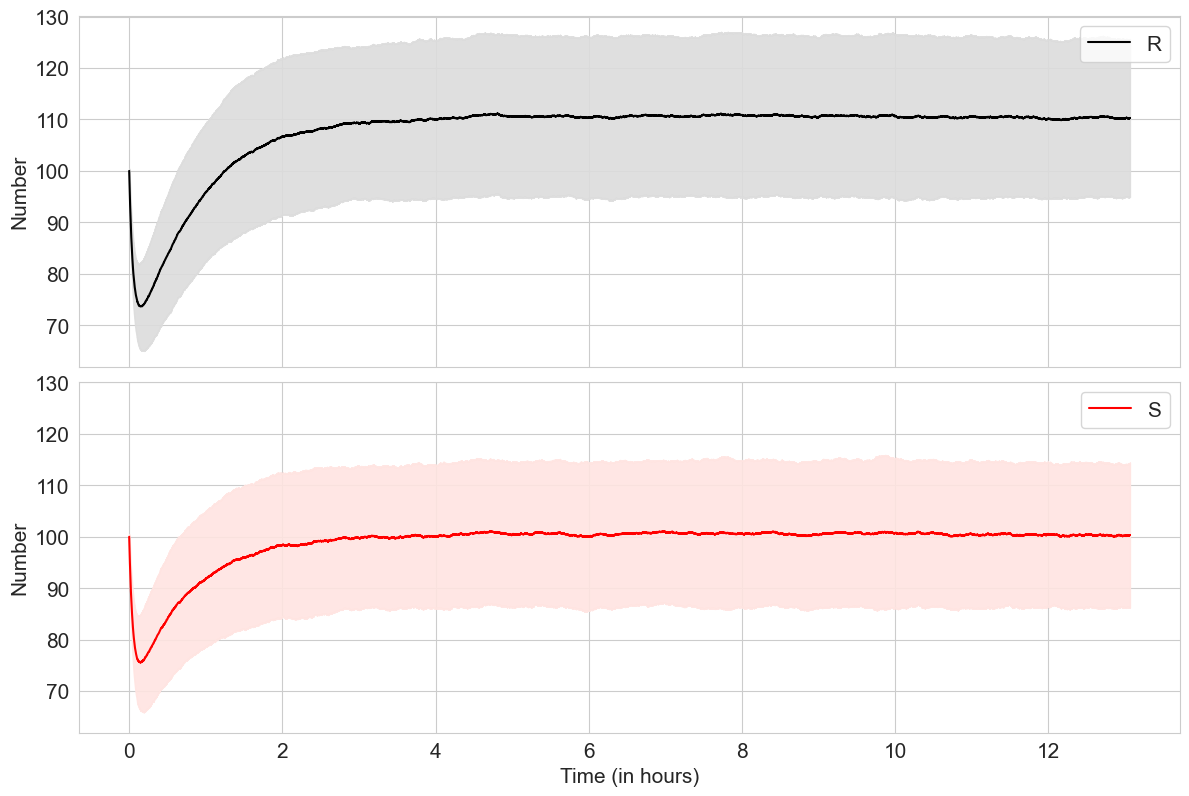

In [28]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)

axs[0].fill_between(unif_time_arr, mean_R-std_R, mean_R+std_R, color='gainsboro',alpha=0.9)
axs[0].plot(unif_time_arr,mean_R,color='black',label = "R")
axs[0].set_ylabel("Number",fontsize=15)
axs[0].legend(fontsize=15)
axs[0].tick_params(axis='both', labelsize=15)

axs[1].fill_between(unif_time_arr, mean_S-std_S, mean_S+std_S, color='mistyrose',alpha=0.9)
axs[1].plot(unif_time_arr,mean_S,color='red',label="S")
axs[1].set_ylabel("Number",fontsize=15)
axs[1].set_xlabel("Time (in hours)",fontsize=15)
axs[1].legend(loc='upper right', fontsize=15)
axs[1].tick_params(axis='both', labelsize=15)

#fig.suptitle('Ensemble average trajectories for experimental quantities')
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Ensemble_average_trajectories_for_experimental_quantities.png",dpi=150)
plt.show()

## Experimental Correlation Functions

We have $\tilde{R}= \tilde{r} + \alpha \tilde{c}$ and $\tilde{S} = \tilde{s}+\tilde{c}$

$$ 
\begin{eqnarray}
A_{R}(\tau) &=& \langle \,\tilde{R}(t+\tau)\;\tilde{R}(t)\,\rangle = \langle \,\{\tilde{r}(t+\tau) + \alpha \tilde{c}(t+\tau)\}\;\{\tilde{r}(t) + \alpha \tilde{c}(t)\}\,\rangle \\
&=& \langle \,\tilde{r}(t+\tau) \;\tilde{r}(t) \,\rangle + \alpha^2\langle \,\tilde{c}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{r}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{r}(t) \,\rangle\\
&=& A_r(\tau) + \alpha^2 A_c(\tau) + \alpha C_{rc}(\tau) + \alpha C_{rc}(-\tau)
\end{eqnarray}
$$

Similarly, 

$$A_{S}(\tau)  = A_s(\tau) + A_c(\tau) + C_{sc}(\tau) + C_{sc}(-\tau)$$

Also,

$$ 
\begin{eqnarray}
C_{RS}(\tau) &=& \langle \,\tilde{R}(t+\tau)\;\tilde{S}(t)\,\rangle = \langle \,\{\tilde{r}(t+\tau) + \alpha \tilde{c}(t+\tau)\}\;\{\tilde{s}(t) + \tilde{c}(t)\}\,\rangle \\
&=& \langle \,\tilde{r}(t+\tau) \;\tilde{s}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{c}(t) \,\rangle + \langle \,\tilde{r}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{s}(t) \,\rangle\\
&=& C_{rs}(\tau) + \alpha A_c(\tau) +  C_{rc}(\tau) + \alpha C_{sc}(-\tau)
\end{eqnarray}
$$

In [29]:
R_stat = mod_R[:,bin_num//2:].flatten()
S_stat = mod_S[:,bin_num//2:].flatten()

mu_R, sigma_R = np.mean(R_stat), np.std(R_stat)
mu_S, sigma_S = np.mean(S_stat), np.std(S_stat)

R_norm = (mod_R[:,bin_num//2:] - r_star - alpha*c_star)/sigma_R
S_norm = (mod_S[:,bin_num//2:] - s_star - c_star)/sigma_S

In [30]:
acf_R = correlation_function(R_norm, R_norm, num_trials, N_tau)
acf_S = correlation_function(S_norm, S_norm, num_trials, N_tau)
cf_RS = pair_correlation_function(R_norm, S_norm, num_trials, N_tau)

In [31]:
mod_acf_R = acf_R[acf_R>=0.07]
mod_unif_time_arr_R = unif_time_arr[:len(mod_acf_R),np.newaxis]

a_R,_,_,_ = np.linalg.lstsq(mod_unif_time_arr_R,np.log(mod_acf_R),rcond=None)
tau_c_R = -1/a_R

mod_acf_S = acf_S[acf_S>=0.07]
mod_unif_time_arr_S = unif_time_arr[:len(mod_acf_S),np.newaxis]

a_S,_,_,_ = np.linalg.lstsq(mod_unif_time_arr_S,np.log(mod_acf_S),rcond=None)
tau_c_S = -1/a_S

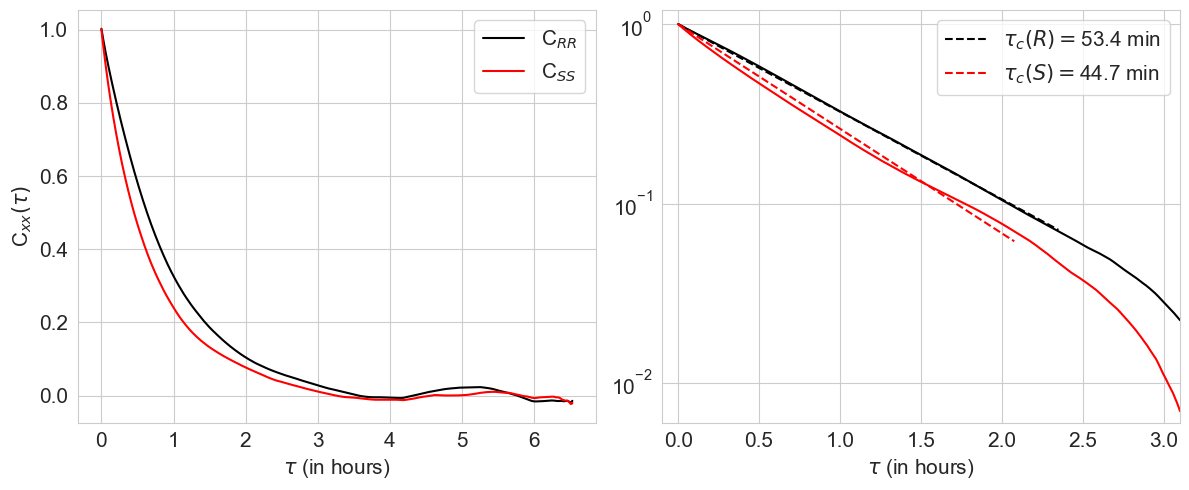

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(acf_tau_arr, acf_R,color='black',label='C$_{RR}$')
axs[0].plot(acf_tau_arr, acf_S,color='red',label='C$_{SS}$')
axs[0].set_xlabel(r"$\tau$ (in hours)",fontsize=15)
axs[0].set_ylabel(r"C$_{xx}(\tau)$",fontsize=15)
axs[0].legend(fontsize=15)
axs[0].tick_params(axis='both', labelsize=15)

axs[1].plot(unif_time_arr[:N_tau],acf_R,color='black')
axs[1].plot(mod_unif_time_arr_R,np.exp(-mod_unif_time_arr_R/tau_c_R),'--',color='black', label=r'$\tau_c(R)=$'+str((tau_c_R[0]*60).round(1))+" min")

axs[1].plot(unif_time_arr[:N_tau],acf_S,color='red')
axs[1].plot(mod_unif_time_arr_S,np.exp(-mod_unif_time_arr_S/tau_c_S),'--',color='red', label=r'$\tau_c(S)=$'+str((tau_c_S[0]*60).round(1))+" min")

axs[1].set_yscale('log',base=10)
axs[1].set_xlabel(r"$\tau$ (in hours)",fontsize=15)
axs[1].legend(loc='upper right',fontsize=15)
axs[1].set_ylim(0.006,1.2)
axs[1].set_xlim(-0.1,3.1)
axs[1].tick_params(axis='both', labelsize=15)

#fig.suptitle("Auto-Correlation Functions \n S = "+str(S))
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Auto_Correlation_Functions_Experimental(S="+str(S)+").png",dpi=150)
plt.show()

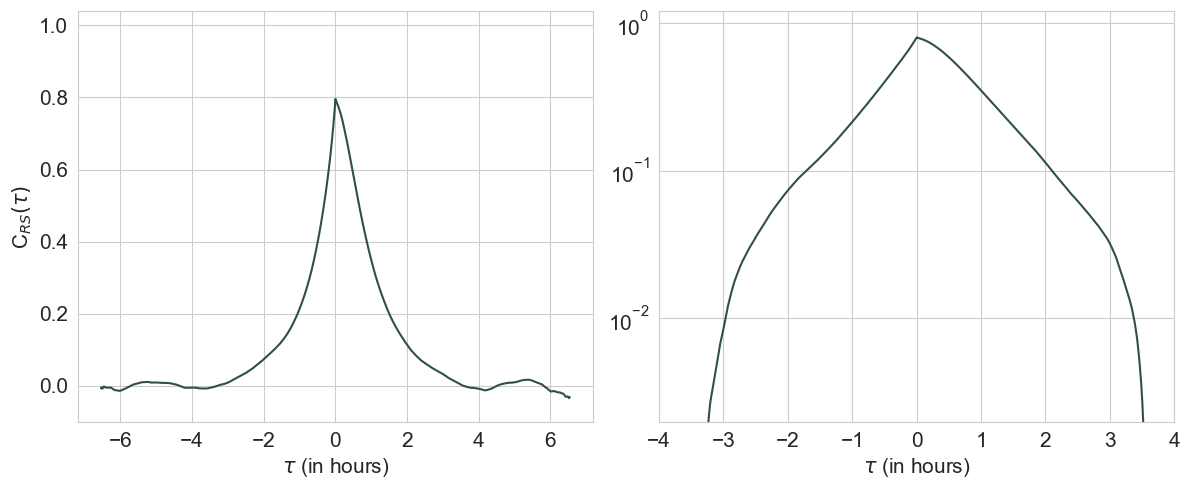

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(cf_tau_arr, cf_RS,color='darkslategray')
axs[0].set_xlabel(r"$\tau$ (in hours)",fontsize=15)
axs[0].set_ylabel(r"C$_{RS}(\tau)$",fontsize=15)
axs[0].set_ylim(-0.1,1.04)
axs[0].tick_params(axis='both', labelsize=15)

axs[1].plot(cf_tau_arr, cf_RS,color='darkslategray')
axs[1].set_xlabel(r"$\tau$ (in hours)",fontsize=15)
axs[1].set_yscale('log',base=10)
axs[1].set_ylim(0.002,1.2)
axs[1].set_xlim(-4,4)
axs[1].tick_params(axis='both', labelsize=15)

#fig.suptitle("Correlation Function \n S = "+str(S))
fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/Correlation_Function_Experimental(S="+str(S)+").png",dpi=150)
plt.show()

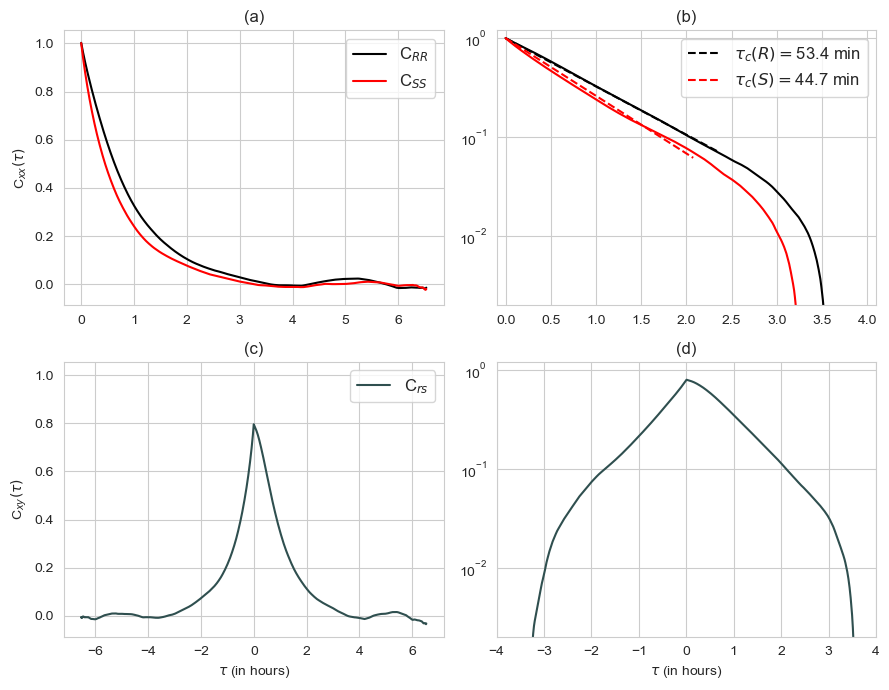

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(9,7),sharey='col')

axs[0,0].plot(acf_tau_arr, acf_R,color='black',label='C$_{RR}$')
axs[0,0].plot(acf_tau_arr, acf_S,color='red',label='C$_{SS}$')
#axs[0,0].set_xlabel(r"$\tau$ (in hours)")
axs[0,0].set_ylabel(r"C$_{xx}(\tau)$")
axs[0,0].legend(fontsize=12, loc='upper right')
axs[0,0].set_title('(a)')

axs[0,1].plot(unif_time_arr[:N_tau],acf_R,color='black')
axs[0,1].plot(mod_unif_time_arr_R,np.exp(-mod_unif_time_arr_R/tau_c_R),'--',color='black', label=r'$\tau_c(R)=$'+str((tau_c_R[0]*60).round(1))+" min")

axs[0,1].plot(unif_time_arr[:N_tau],acf_S,color='red')
axs[0,1].plot(mod_unif_time_arr_S,np.exp(-mod_unif_time_arr_S/tau_c_S),'--',color='red', label=r'$\tau_c(S)=$'+str((tau_c_S[0]*60).round(1))+" min")

axs[0,1].set_yscale('log',base=10)
#axs[0,1].set_xlabel(r"$\tau$ (in hours)")
#axs[0,1].set_ylabel(r"$C_{xx}(\tau)$")
axs[0,1].legend(fontsize=12, loc='upper right')
axs[0,1].set_ylim(0.0008,1.2)
axs[0,1].set_xlim(-0.1,4.1)
axs[0,1].set_title('(b)')


axs[1,0].plot(cf_tau_arr, cf_RS, label="C$_{rs}$", color='darkslategray')
axs[1,0].set_xlabel(r"$\tau$ (in hours)")
axs[1,0].set_ylabel(r"C$_{xy}(\tau)$")
#axs[0].set_ylim(-0.17,0.3)
#axs[0].set_xlim(-0.3,0.3)
axs[1,0].legend(loc='upper right',fontsize=12)
axs[1,0].set_title('(c)')

axs[1,1].plot(cf_tau_arr, cf_RS,color='darkslategray')
axs[1,1].set_xlabel(r"$\tau$ (in hours)")
axs[1,1].set_yscale('log',base=10)
axs[1,1].set_ylim(0.002,1.2)
axs[1,1].set_xlim(-4,4)
axs[1,1].set_title('(d)')

fig.tight_layout()
plt.savefig("/users/nsr/rvasav/Internship/Graphs/AllCorrFuncsExperimental.png",dpi=150)
plt.show()